In [1]:
import os, sys
os.environ['CUDA_VISIBLE_DEVICES'] = '2,3'
from pathlib import Path
import pickle as pkl
import json
from tqdm import tqdm
import numpy as np
from einops import einsum
import pandas as pd
import cv2
from PIL import Image
import lovely_tensors as lt
lt.monkey_patch()
import imageio.v3 as iio
import torch

from pytorch3d.renderer import PerspectiveCameras, PointLights, MeshRenderer, MeshRasterizer, RasterizationSettings, SoftPhongShader
from pytorch3d.renderer import TexturesVertex, Materials
from pytorch3d.structures import Meshes

from hmr4d.dataset.h36m.h36m import H36mSmplDataset #6,196 samples
from hmr4d.utils.body_model import BodyModelSMPLH, BodyModelSMPLX
from hmr4d.utils.geo.hmr_global import get_c_rootparam, get_R_c2gv, get_tgtcoord_rootparam, get_T_w2c_from_wcparams
from hmr4d.utils.geo.hmr_cam import create_camera_sensor
from hmr4d.utils.geo_transform import compute_T_ayfz2ay, apply_T_on_points
from hmr4d.utils.video_io_utils import read_video_np, save_video, get_writer
from hmr4d.utils.vis.renderer import Renderer, get_global_cameras_static, update_intrinsics_from_bbox
from hmr4d.utils.vis.renderer import compute_bbox_from_points, get_ground_params_from_points

device = 'cuda:0'

In [2]:
smpl = BodyModelSMPLH(
    model_path="inputs/checkpoints/body_models", model_type="smpl",
    gender="neutral", num_betas=10, create_body_pose=False, 
    create_betas=False, create_global_orient=False, create_transl=False,
).to(device)
smplx = BodyModelSMPLX(
    model_path="inputs/checkpoints/body_models", model_type="smplx",
    gender="neutral", num_pca_comps=12, flat_hand_mean=False,
).to(device)
smplx2smpl = torch.load("hmr4d/utils/body_model/smplx2smpl_sparse.pt").to(device)
faces_smpl = torch.from_numpy((smpl.faces).astype("int")).unsqueeze(0).to(device)
faces_smplx = torch.from_numpy((smplx.faces).astype("int")).unsqueeze(0).to(device)
J_regressor = torch.load("hmr4d/utils/body_model/smpl_neutral_J_regressor.pt").to(device)

def get_backg_image(vid, idx):
    root_dir = Path("/home/guangyu/qucheng/RegDA_tokenpose/data/Human36M/images")
    camera_idx_to_name = {"54138969": 1, "55011271": 2, "58860488": 3, "60457274": 4}

    subject = int(vid.split('@')[0].replace('S', ''))
    action_name = vid.split('@')[1].rsplit('_', 1)[0]
    subaction_idx = int(vid.split('@')[1].rsplit('_', 1)[1])
    cam_idx = camera_idx_to_name[vid.split('@')[2]]

    tmp = json.loads(Path(f"/home/guangyu/qucheng/RegDA_tokenpose/data/Human36M/annotations/Human36M_subject{subject}_data.json").read_text())
    df = pd.DataFrame(tmp['images'])
    frame_list = df.loc[((df.subject == subject) & (df.action_name == action_name) & (df.subaction_idx == subaction_idx) & (df.cam_idx == cam_idx))]
    frame_name = frame_list.loc[frame_list.frame_idx == idx * 2].file_name.values[0]
    backg = cv2.imread(str(root_dir / frame_name))[...,::-1]
    return backg

In [3]:
dataset = H36mSmplDataset()

np.random.seed(4)
batch = dataset[5]
print(batch['meta'])

length = batch['meta']['start_end'][1] - batch['meta']['start_end'][0]
K = batch['K_fullimg'][0].to(device)
width, height = int(K[0,2])*2, int(K[1,2])*2

[01/01 11:25:12][INFO] [H36M] Loading from inputs/H36M/hmr4d_support/smplxpose_v1.pt ...
[01/01 11:25:12][INFO] [H36M] 600 sequences. Elapsed: 0.60s
[01/01 11:25:12][INFO] [H36M] Fully Loading to RAM ViT-Feat: inputs/H36M/hmr4d_support/vitfeat_h36m.pt
[01/01 11:25:13][INFO] [H36M] Finished. Elapsed: 1.53s
[01/01 11:25:13][INFO] [H36M] has 8.7 hours motion -> Resampled to 6196 samples.


{'data_name': 'h36m', 'idx': 5, 'vid': 'S1@Smoking_1@54138969', 'start_end': (1146, 1266)}


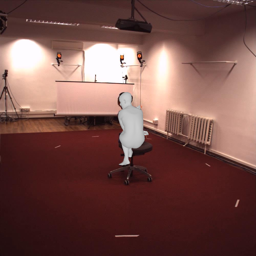

In [5]:
smpl_params_c = {k:v.to(device) for k,v in batch['smpl_params_c'].items()}
verts = smplx(**smpl_params_c).vertices

renderer_c = Renderer(width, height, device="cuda", faces=smplx.faces, K=K)
i = 0
backg = get_backg_image(batch['meta']['vid'], batch['meta']['start_end'][0] + i)
img = renderer_c.render_mesh(verts[i], backg, [0.8, 0.8, 0.8])
Image.fromarray(img).resize((256,256))

# writer = get_writer('tmp.mp4', fps=30, crf=23)
# for i in tqdm(range(length)):
#     backg = get_backg_image(batch['meta']['vid'], batch['meta']['start_end'][0] + i)
#     img = renderer_c.render_mesh(verts[i], backg, [0.8, 0.8, 0.8])
#     writer.write_frame(img)
# writer.close()

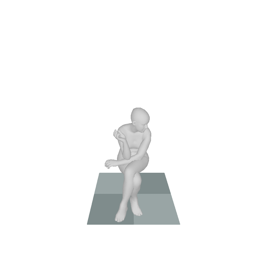

In [8]:
# H36M : gravity vec is az
# batch['smpl_params_w']["global_orient"], batch['smpl_params_w']["transl"], _ = get_tgtcoord_rootparam(
#     batch['smpl_params_w']["global_orient"], 
#     batch['smpl_params_w']["transl"], tsf="az->ay",
# )

smpl_params_w = {k:v.to(device) for k,v in batch['smpl_params_w'].items()}
verts = smplx(**smpl_params_w).vertices
verts = torch.stack([torch.matmul(smplx2smpl, v_) for v_ in verts])

offset = einsum(J_regressor, verts[0], "j v, v i -> j i")[0]  # (3)
offset[1] = verts[:, :, [1]].min()
verts = verts - offset
T_ay2ayfz = compute_T_ayfz2ay(einsum(J_regressor, verts[[0]], "j v, l v i -> l j i"), inverse=True)
verts = apply_T_on_points(verts, T_ay2ayfz)
joints = einsum(J_regressor, verts, "j v, l v i -> l j i")

i = 0
global_R, global_T, global_lights = get_global_cameras_static(
    verts.cpu(), beta=2.0, cam_height_degree=20, target_center_height=1.0, vec_rot=0,
)
_, _, K = create_camera_sensor(width, height, 24)
renderer_g = Renderer(width, height, device="cuda", faces=faces_smpl[0], K=K)

# -- render mesh -- #
scale, cx, cz = get_ground_params_from_points(joints[:, 0], verts)
renderer_g.set_ground(scale * 1.5, cx, cz)
color = torch.ones(3).float().cuda() * 0.8

cameras = renderer_g.create_camera(global_R[i], global_T[i])
img_gb = renderer_g.render_with_ground(verts[[i]], color[None], cameras, global_lights)
Image.fromarray(img_gb).resize((256,256))

In [ ]:
root = Path("inputs/H36M/hmr4d_support")
motion_files = torch.load(root / "smplxpose_v1.pt")
f_img_dicts = torch.load(root / "vitfeat_h36m.pt")

vid = 'S1@Smoking_1@54138969'
idx = 1146

motion = motion_files[vid]
f_img_dict = f_img_dicts[vid]

smpl_params_w = {k: v[idx].unsqueeze(0).to(device) for k, v in motion["smpl_params_glob"].items()}
T_w2c = motion["cam_Rt"]
K = f_img_dict["K_fullimg"].unsqueeze(0).float().to(device)

offset = smplx.get_skeleton(smpl_params_w["betas"][0])[0]  # (3)
global_orient_c, transl_c = get_c_rootparam(
    smpl_params_w["global_orient"], smpl_params_w["transl"], T_w2c.to(device), offset,
)
smpl_params_c = {
    "body_pose": smpl_params_w["body_pose"].clone(),  # (F, 63)
    "betas": smpl_params_w["betas"].clone(),  # (F, 10)
    "global_orient": global_orient_c,  # (F, 3)
    "transl": transl_c,  # (F, 3)
}

smpl_params_w["global_orient"], smpl_params_w["transl"], _ = get_tgtcoord_rootparam(
    smpl_params_w["global_orient"],
    smpl_params_w["transl"],
    tsf="az->ay",
)
        
gravity_vec = torch.tensor([0, 0, -1]).float()  # (3), H36M is az
R_c2gv = get_R_c2gv(T_w2c[..., :3, :3], axis_gravity_in_w=gravity_vec)  # (F, 3, 3)

backg = get_backg_image(vid, idx)

In [ ]:
## Renderer
width, height = int(K[0, 0, 2]) * 2, int(K[0, 1, 2]) * 2

## initialize_camera_params
R = torch.diag(torch.tensor([1, 1, 1])).float().to(device).unsqueeze(0)
T = torch.tensor([0, 0, 0]).unsqueeze(0).float().to(device)
# bboxes = torch.tensor([[0, 0, width, height]]).float()
# K_full, image_sizes = update_intrinsics_from_bbox(K, bboxes)

## update_bbox
## perspective_projection
vertices_c = smplx(**smpl_params_c).vertices
x3d = vertices_c[0, ::50].unsqueeze(0).clone()
x3d = torch.matmul(R, x3d.transpose(1, 2)).transpose(1, 2)
x3d = x3d + T.unsqueeze(-1).transpose(1, 2)
x2d = torch.div(x3d, x3d[..., 2:])
x2d = torch.matmul(K, x2d.transpose(-1, -2)).transpose(-1, -2)[..., :2]
    
bboxes = compute_bbox_from_points(x2d, width, height, 1.2)
print(bboxes)
K_full, image_sizes = update_intrinsics_from_bbox(K, bboxes)
cameras = PerspectiveCameras(device=device, R=R.mT, T=T, K=K_full, image_size=image_sizes, in_ndc=False)

lights = PointLights(device=device, location=[[0.0, 0.0, -10.0]])

## create_renderer
raster_settings = RasterizationSettings(image_size=image_sizes[0], blur_radius=1e-5, bin_size=None)
rasterizer = MeshRasterizer(raster_settings=raster_settings)
shader = SoftPhongShader(device=device, lights=lights)

renderer = MeshRenderer(rasterizer=rasterizer, shader=shader)

tensor[1, 4] x∈[333.000, 674.000] μ=511.500 σ=150.927 cuda:0 [[449.000, 333.000, 590.000, 674.000]]


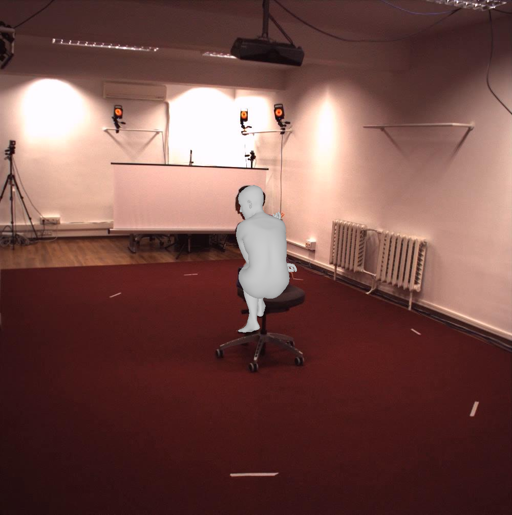

In [ ]:
# img = renderer_c.render_mesh(verts[i], backg, [0.8, 0.8, 0.8])
verts_features = torch.tensor([0.8,0.8,0.8]).reshape(1, 1, 3).to(device=device, dtype=vertices_c.dtype)
verts_features = verts_features.repeat(1, vertices_c.shape[1], 1)
textures = TexturesVertex(verts_features=verts_features)

mesh = Meshes(verts=vertices_c, faces=faces_smplx, textures=textures,)

materials = Materials(device=device, specular_color=([0.8, 0.8, 0.8],), shininess=0)

results = torch.flip(renderer(mesh, materials=materials, cameras=cameras, lights=lights), [1, 2])
image = (results[0, ..., :3].detach().cpu().numpy() * 255).astype(np.uint8)
mask = (results[0, ..., -1].detach().cpu().numpy() > 1e-3).astype(bool)

out_image = backg.copy()
bbox = bboxes[0].int().cpu().numpy().copy()
roi_image = out_image[bbox[1]:bbox[3], bbox[0]:bbox[2]]
roi_image[mask] = image[mask]
out_image[bbox[1]:bbox[3], bbox[0]:bbox[2]] = roi_image
Image.fromarray(out_image).resize((256, 256))

In [15]:
# move_to_start_point_face_z
# verts = smplx_w.vertices.clone()  # (L, V, 3)
smplx_w = smplx(**smpl_params_w)
verts = torch.stack([torch.matmul(smplx2smpl, v_) for v_ in smplx_w.vertices])

offset = einsum(J_regressor, verts[0], "j v, v i -> j i")[0]  # (3)
offset[1] = verts[:, :, [1]].min()
verts = verts - offset
# face direction
T_ay2ayfz = compute_T_ayfz2ay(einsum(J_regressor, verts[[0]], "j v, l v i -> l j i"), inverse=True)
verts = apply_T_on_points(verts, T_ay2ayfz)
joints = einsum(J_regressor, verts, "j v, l v i -> l j i")  # (L, J, 3)


In [16]:

global_R, global_T, global_lights = get_global_cameras_static(
    verts.cpu(), beta=2.0, cam_height_degree=20, target_center_height=1.0,
)
_, _, K = create_camera_sensor(width, height, 24)
renderer_g = Renderer(width, height, device="cuda", faces=faces_smpl[0], K=K)

# -- render mesh -- #
scale, cx, cz = get_ground_params_from_points(joints[:, 0], verts)
renderer_g.set_ground(scale * 1.5, cx, cz)
color = torch.ones(3).float().cuda() * 0.8

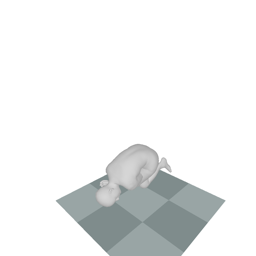

In [17]:
cameras = renderer_g.create_camera(global_R, global_T)
img_gb = renderer_g.render_with_ground(verts, color[None], cameras, global_lights)
Image.fromarray(img_gb).resize((256,256))